In [1]:
%load_ext autoreload
%autoreload 2

# Import packages

In [2]:
from moscot import FusedGW
from ott.geometry.geometry import Geometry
from jax import numpy as jnp

# if trying f64
# from jax.config import config
# config.update("jax_enable_x64", True)

In [3]:
import matplotlib.pyplot as pl
import numpy as np
import ot
from novosparc.reconstruction._GWadjusted import gromov_wasserstein_adjusted_norm

In [4]:
# taken from: https://pythonot.github.io/auto_examples/gromov/plot_fgw.html#sphx-glr-auto-examples-plot-fgw-py
n = 20  # number of points in the first distribution
n2 = 30  # number of points in the second distribution
sig = 1  # std of first distribution
sig2 = 0.1  # std of second distribution

np.random.seed(0)

phi = np.arange(n)[:, None]
xs = phi + sig * np.random.randn(n, 1)
ys = np.vstack((np.ones((n // 2, 1)), 0 * np.ones((n // 2, 1)))) + sig2 * np.random.randn(n, 1)

phi2 = np.arange(n2)[:, None]
xt = phi2 + sig * np.random.randn(n2, 1)
yt = np.vstack((np.ones((n2 // 2, 1)), 0 * np.ones((n2 // 2, 1)))) + sig2 * np.random.randn(n2, 1)
yt = yt[::-1, :]

p = ot.unif(n)
q = ot.unif(n2)

# Visualize the data

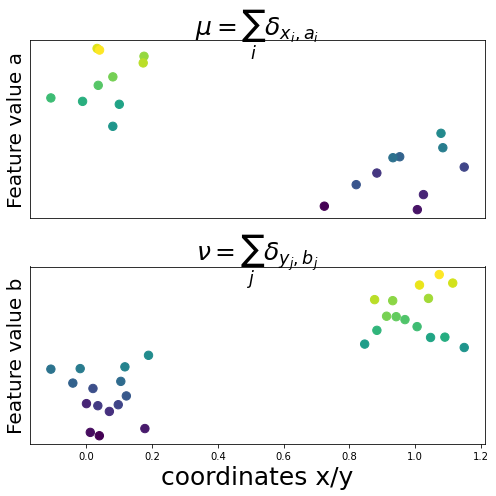

In [5]:
pl.close(10)
pl.figure(10, (7, 7))

pl.subplot(2, 1, 1)

pl.scatter(ys, xs, c=phi, s=70)
pl.ylabel('Feature value a', fontsize=20)
pl.title('$\mu=\sum_i \delta_{x_i,a_i}$', fontsize=25, y=1)
pl.xticks(())
pl.yticks(())
pl.subplot(2, 1, 2)
pl.scatter(yt, xt, c=phi2, s=70)
pl.xlabel('coordinates x/y', fontsize=25)
pl.ylabel('Feature value b', fontsize=20)
pl.title('$\\nu=\sum_j \delta_{y_j,b_j}$', fontsize=25, y=1)
pl.yticks(())
pl.tight_layout()
pl.show()

# Run FGW

## prepare parameters/data

In [6]:
alpha = 1e-3
epsilon = 1e-1
# numerical errors for sinkhorn in POT
# epsilon = 1e-2

C1 = ot.dist(xs)
C2 = ot.dist(xt)
M = ot.dist(ys, yt)
w1 = ot.unif(C1.shape[0])
w2 = ot.unif(C2.shape[0])

## moscot

In [7]:
dtype = np.float32
C1_g = Geometry(cost_matrix=jnp.asarray(C1, dtype=dtype))
C2_g = Geometry(cost_matrix=jnp.asarray(C2, dtype=dtype))
M_g = Geometry(cost_matrix=jnp.asarray(M, dtype=dtype))

1. err=0.12826894223690033 tau=0.0
2. err=0.047398652881383896 tau=0.0
3. err=0.0016604686388745904 tau=0.0
4. err=6.436156581912655e-06 tau=0.0
5. err=4.969887868355727e-06 tau=0.0
6. err=1.2275319022592157e-05 tau=0.0
7. err=4.21150525653502e-06 tau=0.0
8. err=1.0436251614009961e-05 tau=0.0
9. err=2.1056448531453498e-05 tau=0.0
10. err=1.2818939467251766e-05 tau=0.0


Text(0.5, 1.0, 'FGW - scott ($M+C_1,C_2$)')

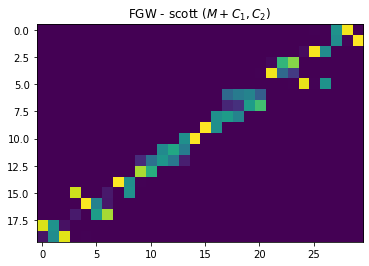

In [8]:
fgwot = FusedGW(alpha=alpha, epsilon=epsilon)
fgwot.fit(C1_g, C2_g, M_g, log=True, n_iters=10, tol=1e-9, novosparc=False)
pl.imshow(fgwot.matrix, cmap='viridis', interpolation='nearest')
pl.title('FGW - scott ($M+C_1,C_2$)')

1. err=0.10680899769067764 tau=0
2. err=0.04920993000268936 tau=0
3. err=0.0003686513809952885 tau=0
4. err=2.9420039027172606e-06 tau=0
5. err=3.06571109831566e-06 tau=0
6. err=3.1710364964965265e-06 tau=0
7. err=3.005598500749329e-06 tau=0
8. err=3.824017312581418e-06 tau=0
9. err=3.156027105433168e-06 tau=0
10. err=2.6191094093519496e-06 tau=0


Text(0.5, 1.0, 'FGW - scott ($M+C_1,C_2$)')

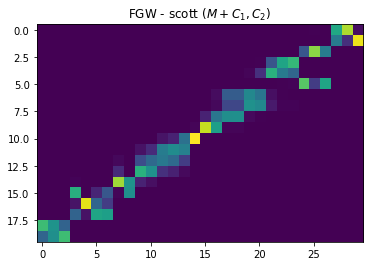

In [9]:
fgwot = FusedGW(alpha=alpha, epsilon=epsilon)

fgwot.fit(C1_g, C2_g, M_g, log=True, n_iters=10, tol=1e-9, novosparc=True)
pl.imshow(fgwot.matrix, cmap='viridis', interpolation='nearest')
pl.title('FGW - scott ($M+C_1,C_2$)')

## novosparc

In [10]:
Gwg = gromov_wasserstein_adjusted_norm(M, C1, C2, alpha_linear=1 - alpha, p=p, q=q,
                                       loss_fun="square_loss", epsilon=epsilon,
                                       random_ini=False, verbose=True)

It.  |Err         
-------------------
    0|1.034371e-01|


Text(0.5, 1.0, 'FGW - novosparc ($M+C_1,C_2$)')

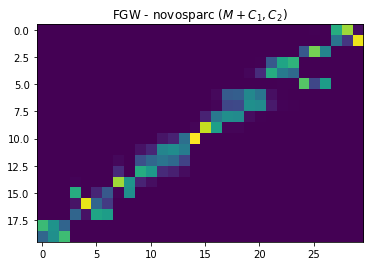

In [11]:
pl.imshow(Gwg, cmap='viridis', interpolation='nearest')
pl.title('FGW - novosparc ($M+C_1,C_2$)')

In [12]:
jnp.max(jnp.abs(fgwot.matrix - Gwg))

DeviceArray(0.00112603, dtype=float32)